In [1]:
from glob import glob
import numpy as np
import pandas as pd
import os
from wepredict.predict import Predict
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%cd /home/robert/Documents/projects/ML_genetic_risk

/home/robert/Documents/projects/ML_genetic_risk


In [3]:
data_folder = 'data/split_test/chr10/'
extension = '*.bed'
files = glob(os.path.join(data_folder, extension))
homedir = '/home/robert/Documents/projects/ML_genetic_risk'

In [4]:
train_files = [os.path.join(homedir, f.replace('.bed', '')) for f in files if 'train' in f]
dev_files = [os.path.join(homedir, f.replace('.bed', '')) for f in files if 'dev' in f]
assert len(train_files) == len(dev_files)
print(train_files[0], dev_files[0])
assert len(train_files) > 1

/home/robert/Documents/projects/ML_genetic_risk/data/split_test/chr10/SampleMajor_10_134494673_135523865_train /home/robert/Documents/projects/ML_genetic_risk/data/split_test/chr10/SampleMajor_10_125869346_128001098_dev


In [5]:
train_files, dev_files = sorted(train_files), sorted(dev_files)

In [6]:
pheno = 'data/sim_1000G_chr10.txt'
pheno = os.path.join(homedir, pheno)
dd = pd.read_table(pheno)
dd.head()

,FID,IID,PAT,MAT,SEX,V6,V1,V2,V3,V4
0,0,HG00096,0,0,0,-9,1.391821,1.138268,2.070238,-0.372672
1,0,HG00097,0,0,0,-9,-1.187275,2.092036,0.692091,0.048933
2,0,HG00099,0,0,0,-9,0.133182,0.638893,-0.529870,-1.335510
3,0,HG00100,0,0,0,-9,-1.170558,1.796703,1.220772,-1.487219
4,0,HG00101,0,0,0,-9,1.556918,1.210081,-1.837264,-0.456114


In [7]:
pheno_names = ['V'+str(k) for k in range(1, 5)]

In [8]:
train_dev_pairs = [k for k in zip(train_files, dev_files)]

In [49]:
def l1_predict(train_dev_pair, pheno, pheno_name):
    train, dev = train_dev_pair

    la = [0.0001, 0.001, 0.01, 0.1]
    models = list()
    for l in la: 
        model = Predict(train, dev, pheno, 100)
        model.fit(pheno_name, 'l1', 0.01, 0.01, logging_freq=10, epochs=50)
        models.append(model)
    return models

In [17]:
import logging

In [18]:
#logging.basicConfig(level=logging.INFO)
#t_test = l1_predict(train_dev_pairs[0], pheno, 'V1')

In [19]:
#t_test

In [20]:
import ipyparallel as ipp

In [51]:
c = ipp.Client()
v = c[:]
v.execute('from wepredict.predict import Predict')
datadic = dict(pheno=pheno, pheno_name='V1', l1_predict=l1_predict)
v.push(datadic)
lambdfun = lambda p:l1_predict(p, pheno, pheno_name)

/home/robert/software/anaconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@rmporsch')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [ ]:
out = v.map_sync(lambdfun, train_dev_pairs)

In [23]:
test = out[0]

In [24]:
import pickle

In [25]:
pickle.dump(out, open('pheno1_l1_1kg.pickle', 'wb'))

In [46]:
loss = [k.results.loss for k in out]
prediction = [k.results.iter_accu_valid for k in out]

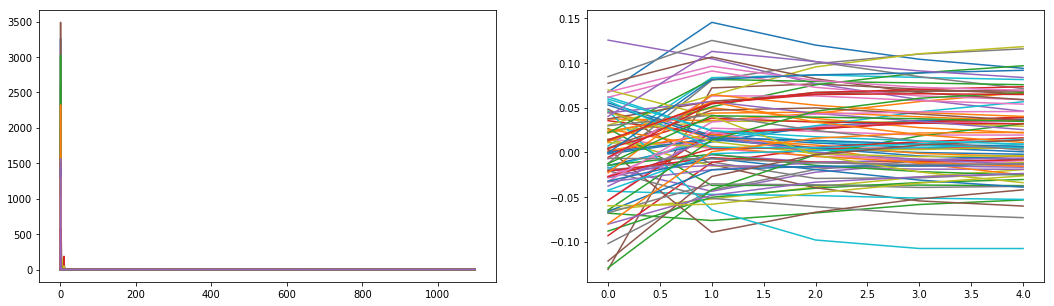

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
for k in loss:
    ax[0].plot(range(len(k)), k)
for k in prediction:
    ax[1].plot(range(len(k)), k)

In [29]:
pred = sum([k.results.prediction_valid for k in out])

In [39]:
fam_dev = 'data/split_test/chr10/SampleMajor_10_100241302_100668400_dev.fam'
fam_dev = pd.read_table(fam_dev, header=None)
dev = dd[dd.IID.isin(fam_dev.iloc[:, 1])]

In [41]:
np.corrcoef(dev.V1, pred)

array([[1.        , 0.06658893],
       [0.06658893, 1.        ]])

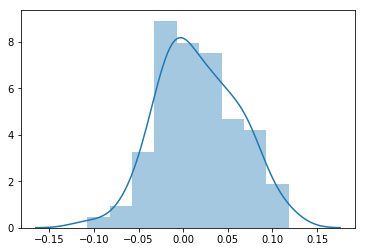

In [48]:
sns.distplot([k[-1] for k in prediction])

In [44]:
prediction

NameError: name 'prediction' is not defined